In [6]:
import os
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END
from IPython.display import Image, display

from dotenv import load_dotenv # load enviornment variables
load_dotenv()

# connect to OpenAI
openai_api_key = os.environ.get("OPENAI_API_KEY")
openai_organization = os.environ.get("OPENAI_ORGANIZATION")

model = ChatOpenAI(
    openai_api_key = openai_api_key, 
    openai_organization = openai_organization,
    model = "gpt-4o-mini")

def agent_1(state: MessagesState) -> Command[Literal["agent_2", "agent_3", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    response = model.invoke(...)
    # route to one of the agents or exit based on the LLM's decision
    # if the LLM returns "__end__", the graph will finish execution
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )

def agent_2(state: MessagesState) -> Command[Literal["agent_1", "agent_3", END]]:
    response = model.invoke(...)
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )

def agent_3(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    ...
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )

builder = StateGraph(MessagesState)
builder.add_node(agent_1)
builder.add_node(agent_2)
builder.add_node(agent_3)

builder.add_edge(START, "agent_1")
network = builder.compile()

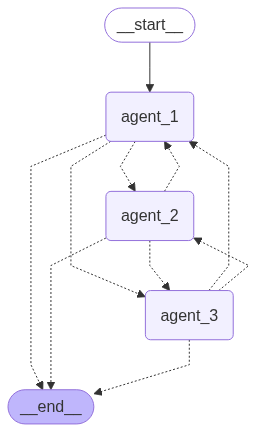

In [7]:
display(Image(network.get_graph().draw_mermaid_png()))

In [8]:
from rich import inspect

In [9]:
inspect(Command)

╭─────────────────────────────────────── <class 'langgraph.types.Command'> ───────────────────────────────────────╮
│ class Command(*, graph: Optional[str] = None, update: Optional[Any] = None, resume: Union[Any, dict[str, Any],  │
│ NoneType] = None, goto: Union[langgraph.types.Send, Sequence[Union[langgraph.types.Send, str]], str] = ()) ->   │
│ None:                                                                                                           │
│                                                                                                                 │
│ One or more commands to update the graph's state and send messages to nodes.                                    │
│                                                                                                                 │
│   goto = <member 'goto' of 'Command' objects>                                                                   │
│  graph = <member 'graph' of 'Command' objects>                                                                  │
│ PARENT = '__parent__'                                                                                           │
│ resume = <member 'resume' of 'Command' objects>                                                                 │
│ update = <member 'update' of 'Command' objects>                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
help(Command)

Help on class Command in module langgraph.types:

class Command(typing.Generic, langchain_core.messages.tool.ToolOutputMixin)
 |  Command(
 |      *,
 |      graph: Optional[str] = None,
 |      update: Optional[Any] = None,
 |      resume: Union[Any, dict[str, Any], NoneType] = None,
 |      goto: Union[langgraph.types.Send, Sequence[Union[langgraph.types.Send, str]], str] = ()
 |  ) -> None
 |
 |  One or more commands to update the graph's state and send messages to nodes.
 |
 |  Args:
 |      graph: graph to send the command to. Supported values are:
 |
 |          - None: the current graph (default)
 |          - Command.PARENT: closest parent graph
 |      update: update to apply to the graph's state.
 |      resume: value to resume execution with. To be used together with [`interrupt()`][langgraph.types.interrupt].
 |      goto: can be one of the following:
 |
 |          - name of the node to navigate to next (any node that belongs to the specified `graph`)
 |          - sequenc

In [11]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

model = ChatOpenAI()

def supervisor(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    response = model.invoke(...)
    # route to one of the agents or exit based on the supervisor's decision
    # if the supervisor returns "__end__", the graph will finish execution
    return Command(goto=response["next_agent"])

def agent_1(state: MessagesState) -> Command[Literal["supervisor"]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # and add any additional logic (different models, custom prompts, structured output, etc.)
    response = model.invoke(...)
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

def agent_2(state: MessagesState) -> Command[Literal["supervisor"]]:
    response = model.invoke(...)
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

builder = StateGraph(MessagesState)
builder.add_node(supervisor)
builder.add_node(agent_1)
builder.add_node(agent_2)

builder.add_edge(START, "supervisor")

supervisor = builder.compile()

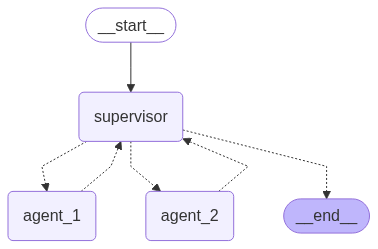

In [12]:
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [14]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
model = ChatOpenAI()

# define team 1 (same as the single supervisor example above)

class Team1State(MessagesState):
    next: Literal["team_2_agent_1", "team_2_agent_2", "__end__"]

def team_1_supervisor(state: MessagesState) -> Command[Literal["team_1_agent_1", "team_1_agent_2", END]]:
    response = model.invoke(...)
    return Command(goto=response["next_agent"])

def team_1_agent_1(state: MessagesState) -> Command[Literal["team_1_supervisor"]]:
    response = model.invoke(...)
    return Command(goto="team_1_supervisor", update={"messages": [response]})

def team_1_agent_2(state: MessagesState) -> Command[Literal["team_1_supervisor"]]:
    response = model.invoke(...)
    return Command(goto="team_1_supervisor", update={"messages": [response]})

team_1_builder = StateGraph(Team1State)
team_1_builder.add_node(team_1_supervisor)
team_1_builder.add_node(team_1_agent_1)
team_1_builder.add_node(team_1_agent_2)
team_1_builder.add_edge(START, "team_1_supervisor")
team_1_graph = team_1_builder.compile()

# define team 2 (same as the single supervisor example above)
class Team2State(MessagesState):
    next: Literal["team_2_agent_1", "team_2_agent_2", "__end__"]

def team_2_supervisor(state: Team2State):
    ...

def team_2_agent_1(state: Team2State):
    ...

def team_2_agent_2(state: Team2State):
    ...

team_2_builder = StateGraph(Team2State)
...
team_2_graph = team_2_builder.compile()


# define top-level supervisor

builder = StateGraph(MessagesState)
def top_level_supervisor(state: MessagesState) -> Command[Literal["team_1_graph", "team_2_graph", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which team to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_team" field)
    response = model.invoke(...)
    # route to one of the teams or exit based on the supervisor's decision
    # if the supervisor returns "__end__", the graph will finish execution
    return Command(goto=response["next_team"])

builder = StateGraph(MessagesState)
builder.add_node(top_level_supervisor)
builder.add_node("team_1_graph", team_1_graph)
builder.add_node("team_2_graph", team_2_graph)
builder.add_edge(START, "top_level_supervisor")
builder.add_edge("team_1_graph", "top_level_supervisor")
builder.add_edge("team_2_graph", "top_level_supervisor")
graph = builder.compile()

ValueError: Graph must have an entrypoint: add at least one edge from START to another node